# 상층 일기도+연습

상층 일기도는 가장 하단부에 작성되어있음  

앞부분에 다른 시도도 포함됨

## nc 기압도 그리기(예제)
ERA5 재분석장 자료 사용

In [2]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': [
            '2m_temperature', 'mean_sea_level_pressure',
        ],
        'year': '2019',
        'month': '9',
        'day': '5',
        'time': '00:00',
        'grid': [0.25, 0.25],
    },
    'era5_sfc_2019090500.nc')

2020-12-03 22:08:46,828 INFO Welcome to the CDS
2020-12-03 22:08:46,828 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2020-12-03 22:08:48,276 INFO Request is queued
2020-12-03 22:08:49,561 INFO Request is running
2020-12-03 22:08:51,382 INFO Request is completed
2020-12-03 22:08:51,388 INFO Downloading http://136.156.132.153/cache-compute-0002/cache/data4/adaptor.mars.internal-1607000928.2756062-8646-19-c4dfd40c-da2d-4a79-bc58-71ba47f59177.nc to era5_sfc_2019090500.nc (4M)
2020-12-03 22:09:02,860 INFO Download rate 354.4K/s 


Result(content_length=4162968,content_type=application/x-netcdf,location=http://136.156.132.153/cache-compute-0002/cache/data4/adaptor.mars.internal-1607000928.2756062-8646-19-c4dfd40c-da2d-4a79-bc58-71ba47f59177.nc)

In [1]:
import xarray as xr

In [2]:
ds = xr.open_dataset('era5_sfc_2019090500.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2019-09-05
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-12-03 13:08:49 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

# 지상일기도 작성

In [3]:
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

In [4]:
dtt = datetime(2019, 9, 5, 0)

# Select and grab data, at/lon values 
pres = ds['msl'].sel(time=dtt,latitude=slice(90,0), longitude=slice(60,201))
lats = pres.latitude.data
lons = pres.longitude.data

# Select and grab surface pressure, smooth with gaussian_filter
#pres = gaussian_filter(pres.data, sigma=0) / 100. * units('hPa')
pres = pres.data/100*units('hPa')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

In [5]:
def plot_maxmin_points(lon, lat, data, extrema, nsize, symbol, color='k',
                       plotValue=True, transform=None):
    """
    This function will find and plot relative maximum and minimum for a 2D grid. The function
    can be used to plot an H for maximum values (e.g., High pressure) and an L for minimum
    values (e.g., low pressue). It is best to used filetered data to obtain  a synoptic scale
    max/min value. The symbol text can be set to a string value and optionally the color of the
    symbol and any plotted value can be set with the parameter color.

    Parameters
    ----------
        lon : 2D array
            Plotting longitude values
        lat : 2D array
            Plotting latitude values
        data : 2D array
            Data that you wish to plot the max/min symbol placement
        extrema : str
            Either a value of max for Maximum Values or min for Minimum Values
        nsize : int
            Size of the grid box to filter the max and min values to plot a reasonable number
        symbol : str
            Text to be placed at location of max/min value
        color : str
            Name of matplotlib colorname to plot the symbol (and numerical value, if plotted)
        plot_value : Boolean (True/False)
            Whether to plot the numeric value of max/min point

    Return
    ------
        The max/min symbol will be plotted on the current axes within the bounding frame
        (e.g., clip_on=True)
    """
    from scipy.ndimage.filters import maximum_filter, minimum_filter

    if (extrema == 'max'):
        data_ext = maximum_filter(data, nsize, mode='mirror')
    elif (extrema == 'min'):
        data_ext = minimum_filter(data, nsize, mode='mirror')
    else:
        raise ValueError('Value for hilo must be either max or min')

    if lon.ndim == 1:
        lon, lat = np.meshgrid(lon, lat)

    mxx, mxy = np.where(data_ext == data)

    for i in range(len(mxy)):
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], symbol, color=color, size=36,
                clip_on=True, horizontalalignment='center', verticalalignment='center',
                transform=transform)
        ax.text(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                '\n' + str(np.int(data[mxx[i], mxy[i]])),
                color=color, size=12, clip_on=True, fontweight='bold',
                horizontalalignment='center', verticalalignment='top', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]], marker='o', markeredgecolor='black',
                markerfacecolor='white', transform=transform)
        ax.plot(lon[mxx[i], mxy[i]], lat[mxx[i], mxy[i]],
                marker='x', color='black', transform=transform)

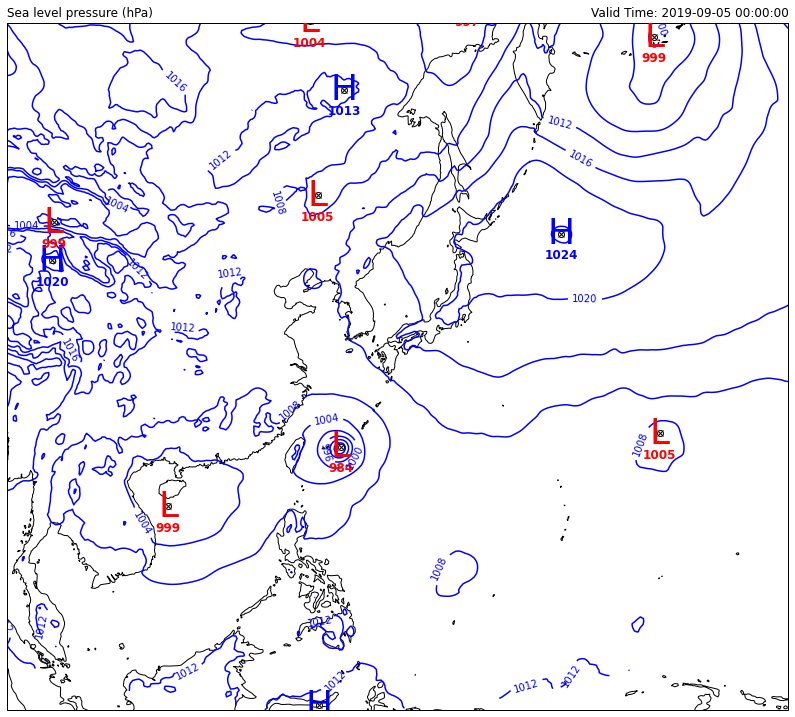

In [25]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.EquidistantConic(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
#ax.set_extent([90, 160, 20, 60], ccrs.PlateCarree())
ax.set_extent([100, 160, 0, 60], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, pres.to('hPa'), clevs_pres, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols
plot_maxmin_points(lons, lats, pres.m, 'max', 80,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(lons, lats, pres.m, 'min', 85,
                   symbol='L', color='red', transform=ccrs.PlateCarree())


# Make some nice titles for the plot (one right, one left)
plt.title('Sea level pressure (hPa)',
           loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

## 태풍 경로 상에서 현재의 태풍 위치 표시(발표에는 사용안함)

기상청 태풍 찾아보기 https://www.weather.go.kr/weather/typoon/typhoon_06_01.jsp  
링링 검색 후 나오는 중심 좌표 및 강풍 반경 csv 파일로 저장하여 사용 

In [6]:
import pandas as pd
import matplotlib as mplt

data = {}
path7 = r'/Users/hojjunekim/Desktop/Final_project/LingLing.csv'
ring = pd.read_csv(path7)
data['Ling_longitude'] = ring['longitude'].values
data['Ling_latitude'] = ring['latitude'].values
data['Ling_radius'] = ring['radius'].values
data['UTC'] = ring['date'].values+' '+ring['UTC'].values

print(data['UTC'][1]=='2019-09-05 00:00')

False


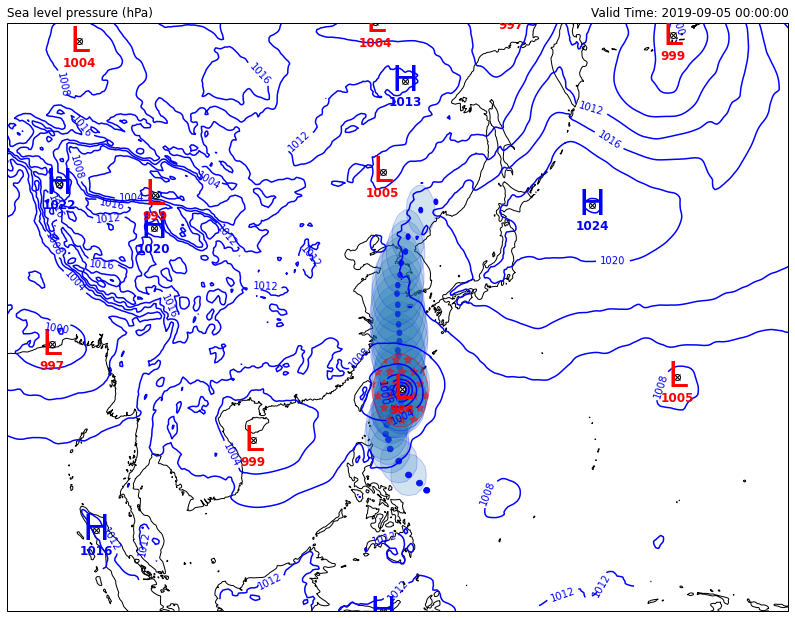

In [7]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.EquidistantConic(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([90, 160, 0, 60], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot surface pressure in hPa
clevs_pres = np.arange(860, 1100, 4)
cs = ax.contour(lons, lats, pres.to('hPa'), clevs_pres, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Use definition to plot H/L symbols
plot_maxmin_points(lons, lats, pres.m, 'max', 80,
                   symbol='H', color='blue', transform=ccrs.PlateCarree())
plot_maxmin_points(lons, lats, pres.m, 'min', 80,
                   symbol='L', color='red', transform=ccrs.PlateCarree())


#ringring plot
for i in range(len(data['Ling_longitude'])):
    #ax.text(data['ring_longitude'][i], data['ring_latitude'][i], '.', color = 'blue', size=60,
    #        horizontalalignment='center', verticalalignment='center', clip_on=True, transform=ccrs.PlateCarree())

    try:
        width = int(data['Ling_radius'][i])/110
        height = int(data['Ling_radius'][i])/90
        r = width
    except:
        width = 0
        height = 0
        r = 0
    if data['UTC'][i]=='2019-09-05 0:00':
        ellipseR = mplt.patches.Ellipse((data['Ling_longitude'][i], data['Ling_latitude'][i]), 2*width,2*height, ec = 'r', transform=ccrs.PlateCarree(), alpha=0.5, hatch='*')
        circleR = plt.Circle((data['Ling_longitude'][i], data['Ling_latitude'][i]), 0.3, ec = 'r', fc = 'r', transform=ccrs.PlateCarree())
    else:
        ellipse = mplt.patches.Ellipse((data['Ling_longitude'][i], data['Ling_latitude'][i]), 2*width,2*height, ec = 'b', transform=ccrs.PlateCarree(), alpha=0.2)
        circle = plt.Circle((data['Ling_longitude'][i], data['Ling_latitude'][i]), 0.3, ec = 'b', fc = 'b', transform=ccrs.PlateCarree())
    ax.add_artist(ellipse)
    ax.add_artist(circle)

ax.add_artist(ellipseR)
ax.add_artist(circleR)

# Make some nice titles for the plot (one right, one left)
plt.title('Sea level pressure (hPa)',
           loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

## 상층 일기도 (200, 500, 700hPa)

ERA5 재분석장 자료 사용  
grid 0.25, 0.25로 설정하여 25km 격자 자료로 사용  
gaussian filter 사용 안함(주석 처리 또는 sigma = 0)

In [9]:
import cdsapi

c = cdsapi.Client()

dt = datetime(2019, 9, 1, 0)
path = '/Users/hojjunekim/Desktop/Final_project/'
fname = 'era5_pres_' + dt.strftime("%Y%m%d%H") + '.nc'
c.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'format': 'netcdf',
        'variable': 
        ['temperature', 'geopotential', 'u_component_of_wind', 'v_component_of_wind'],
        'pressure_level': 
        ['200', '300', '500','700', '850', '925','1000'],
        'year': dt.year,
        'month': dt.month,
        'day': dt.day,
        'time': dt.hour,
        'grid': [0.25, 0.25],
    },
    path + fname)

2020-12-03 23:39:18,119 INFO Welcome to the CDS
2020-12-03 23:39:18,120 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2020-12-03 23:39:19,376 INFO Request is completed
2020-12-03 23:39:19,378 INFO Downloading http://136.156.132.210/cache-compute-0005/cache/data9/adaptor.mars.internal-1606994470.6545374-13851-37-8603f36a-fdf9-4d8c-9f24-d70c1c708915.nc to /Users/hojjunekim/Desktop/Final_project/era5_pres_2019090100.nc (55.5M)
2020-12-03 23:39:58,725 INFO Download rate 1.4M/s   


Result(content_length=58152212,content_type=application/x-netcdf,location=http://136.156.132.210/cache-compute-0005/cache/data9/adaptor.mars.internal-1606994470.6545374-13851-37-8603f36a-fdf9-4d8c-9f24-d70c1c708915.nc)

In [6]:
dt = datetime(2019, 9, 7, 0)
path = '/Users/hojjunekim/Desktop/Final_project/'
fname = 'era5_pres_' + dt.strftime("%Y%m%d%H") + '.nc'

ds2 = xr.open_dataset(path+fname)

# Select and grab data, at/lon values 
lvl = 200  #change the level if you want other level; 500 700
g = 9.806
#msl = ds1['msl'].sel(time=dt,latitude=slice(90,0), longitude=slice(60,201))[...]
gh = ds2['z'].sel(time=dt, level=lvl, latitude=slice(90,0), longitude=slice(60,201))[...]
t = ds2['t'].sel(time=dt, level=lvl, latitude=slice(90,0), longitude=slice(60,201))[...]
u = ds2['u'].sel(time=dt, level=lvl, latitude=slice(90,0), longitude=slice(60,201))
v = ds2['v'].sel(time=dt, level=lvl, latitude=slice(90,0), longitude=slice(60,201))
lats = gh.latitude.data
lons = gh.longitude.data

# Select and grab surface pressure, smooth with gaussian_filter
#msl = gaussian_filter(msl.data, sigma=0) / 100. * units('hPa')
gh = gaussian_filter(gh.data, sigma=0) / g *units('m')
u = gaussian_filter(u.data, sigma=0) * units('m/s')
v = gaussian_filter(v.data, sigma=0) * units('m/s')
t = gaussian_filter(t.data, sigma=0) * units('K')
wind = mpcalc.wind_speed(u, v).to('kt')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds2.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

<ipython-input-9-978a4b37fd23>:46: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  mxx, mxy = np.where(data_ext == data)


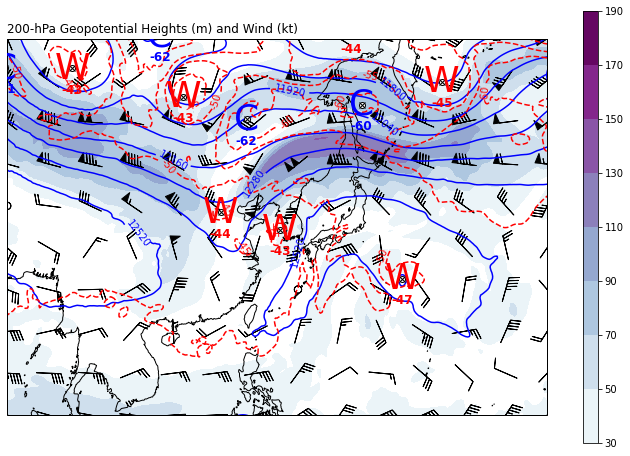

In [10]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=125,
                               central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(20, 12))
domain = [90, 160, 10, 60]

## pressure level
ax = fig.add_subplot(122, projection=mapcrs)
ax.set_extent(domain, ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot lvl-hPa Colorfill Wind Speeds in knots
clevs_wind = np.arange(30, 200, 20)
cf = ax.contourf(lons, lats, wind, clevs_wind, cmap=plt.cm.BuPu,
                 transform=datacrs)
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.25, 0.01, 0.5])
fig.colorbar(cf, orientation='vertical', shrink=0.5, cax=cbar_ax)

# Plot lvl-hPa Geopotential Heights in meters
clevs_gh = np.arange(40, 15000, 120)
cs = ax.contour(lons, lats, gh, clevs_gh, colors='blue', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot lvl-hPa temperatue in degC
clevs_t = np.arange(-60, 5, 5)
cs = ax.contour(lons, lats, t.to('degC'), clevs_t, colors='red', 
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot lvl-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lons, lats, u.to('kt').m, v.to('kt').m, pivot='middle',regrid_shape=10, 
         color='black',  transform=datacrs)


#plot H/L symbols
plot_maxmin_points(lons, lats, gh, 'max', 3,
                   symbol='H', color='blue', transform=datacrs)
plot_maxmin_points(lons, lats, gh, 'min', 3,
                   symbol='L', color='red', transform=datacrs)

#plot W/C symbols
plot_maxmin_points(lons, lats, t.to('degC').m, 'max', 80,
                  symbol='W', color='red', transform=datacrs)
plot_maxmin_points(lons, lats, t.to('degC').m, 'min', 80,
                  symbol='C', color='blue', transform=datacrs)


# Make some nice titles for the plot (one right, one left)
ax.set_title('200-hPa Geopotential Heights (m) and Wind (kt)'
              ,loc='left')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)

# # Adjust image and show
# fig.tight_layout(rect=[0, 0, 0.975, 0.99])